# Preprocessing

In [1]:
import mne
from mne.preprocessing import ICA, create_eog_epochs
import numpy as np
%matplotlib qt

## load data

In [18]:
load_filename = 'MST040_POST_REST_EC'

path = '/Volumes/VLabA/ect_mst/DATA/clean_MST/' + load_filename + '.fif'# name of EMBARC fifle

save_path = '/Volumes/VLabA/ect_mst/DATA/clean_MST/' # name of folder with preprocessed data
save_filename = save_path + load_filename + '.fif'  # preprocessed data file name

In [19]:
raw = mne.io.read_raw(path, preload=True)

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST/MST040_POST_REST_EC.fif...
    Range : 0 ... 620359 =      0.000 ...   620.359 secs
Ready.
Reading 0 ... 620359  =      0.000 ...   620.359 secs...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_26792/1078448403.py:1: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST/MST040_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(path, preload=True)


In [21]:
# print the channels contained in the file, if any are not EEG channels, you'll need change their channel type
raw.info

<Info | 12 non-empty values
 bads: 1 items (CPZ)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 60 EEG, 4 misc
 custom_ref_applied: True
 dig: 63 items (3 Cardinal, 60 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>

In [7]:
# this example file has 2 channels that aren't EEG (nose and nasion, which are often used for references,
# but I don't want them to be included as eeg in the analysis) so I change their channel types to 'misc'

chan_dict = {'EMG': 'emg',
             'EKG': 'ecg',
            'CB1': 'misc',
            'CB2': 'misc',
            'VEO': 'eog',
            'HEO': 'eog',
            'M1': 'misc',
            'M2': 'misc'}

raw.set_channel_types(chan_dict);

ValueError: This channel name (EMG) doesn't exist in info.

In [7]:
# this is the montage of the electrodes, a standardized spatial organization where each electrode has a
# coordiate in space. Spatial location is needed to run things like ICA

raw.set_montage('standard_1020', match_case=False);

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_91037/2201494832.py:4: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['M1', 'M2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020', match_case=False);


## plot raw data

Basic first-pass inspection so you know what you're dealing with. What kinds of artifacts are there? Eyeblinks (big ~1 sec deflections in frontal electrodes like AF7, F3, etc.)

Navigate in the interactive window with arrow keys. You can change aspects of the plotting window using the parameters in the plot() function https://mne.tools/stable/generated/mne.viz.plot_raw.html

### Downsample data (10k Hz --> 1k Hz)

In [8]:
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 60 EEG, 4 misc, 2 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 63 items (3 Cardinal, 60 EEG)
 highpass: 0.0 Hz
 lowpass: 5000.0 Hz
 meas_date: unspecified
 nchan: 68
 projs: []
 sfreq: 10000.0 Hz
 subject_info: 5 items (dict)
>

In [4]:
raw.resample(1000)

<RawCNT | MST009_PRE_REST_EC.cnt, 68 x 1297120 (1297.1 s), ~673.0 MB, data loaded>

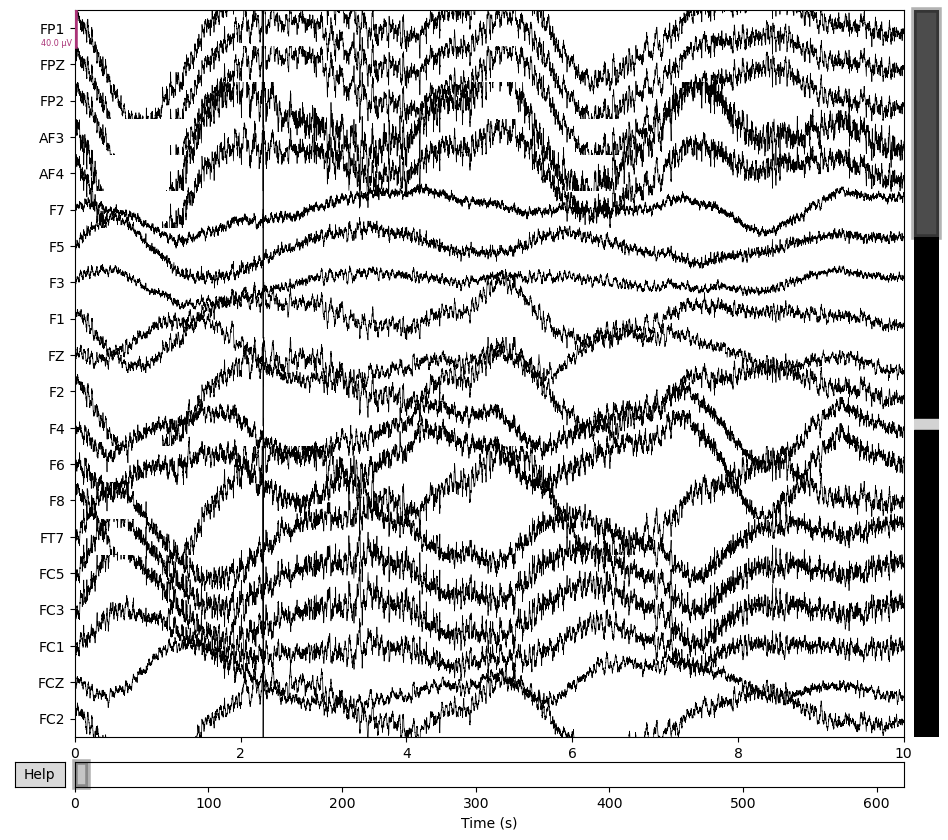

Channels marked as bad: ['CPZ']


In [22]:
raw.plot()

In [23]:
# interpolate channels (post-cleaning fixes)

raw.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 90.6 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors


<Raw | MST040_POST_REST_EC.fif, 64 x 620360 (620.4 s), ~303.0 MB, data loaded>

In [24]:
raw.save(save_filename, overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing /Volumes/VLabA/ect_mst/DATA/clean_MST/MST040_POST_REST_EC.fif


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_26792/2419259305.py:1: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST/MST040_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_filename, overwrite=True)


Closing /Volumes/VLabA/ect_mst/DATA/clean_MST/MST040_POST_REST_EC.fif
[done]


## drop bad channels interactively

Click on channels in the raw plot window that have abnormally noisy/dead signals. You can also check this in the PSD plotted below. Bad channels usually stick out by having PSDs way above or way below the rest of the channels. 

Effective window size : 2.048 (s)


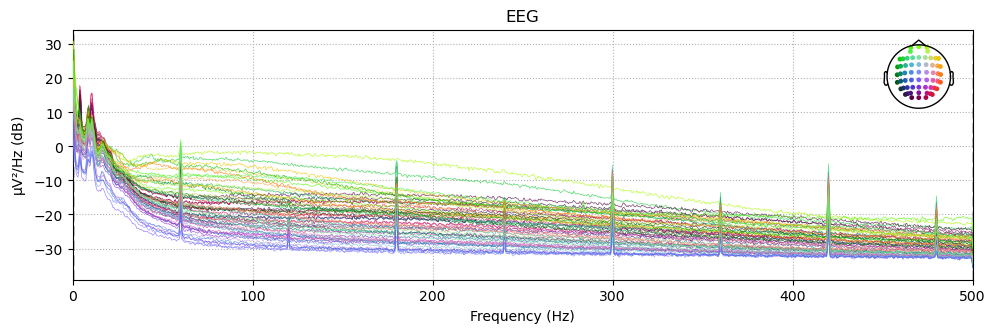

In [24]:
raw.plot_psd()

## rereference

Referencing is usually a good idea. Some systems have their own reference electrodes. Depending on what you're planning to do, you can rereference accordingly (to mastoid electrode, nose electrode, average of all electrodes, etc.). It's good to do your own research for how to reference.

It's good practice to plot the data each time you make a change (reference, filter, etc.) just as a sanity check.

In [29]:
raw.set_eeg_reference(ref_channels=['M1', 'M2'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawCNT | MST160_PRE_REST_EC.cnt, 68 x 727080 (727.1 s), ~377.3 MB, data loaded>

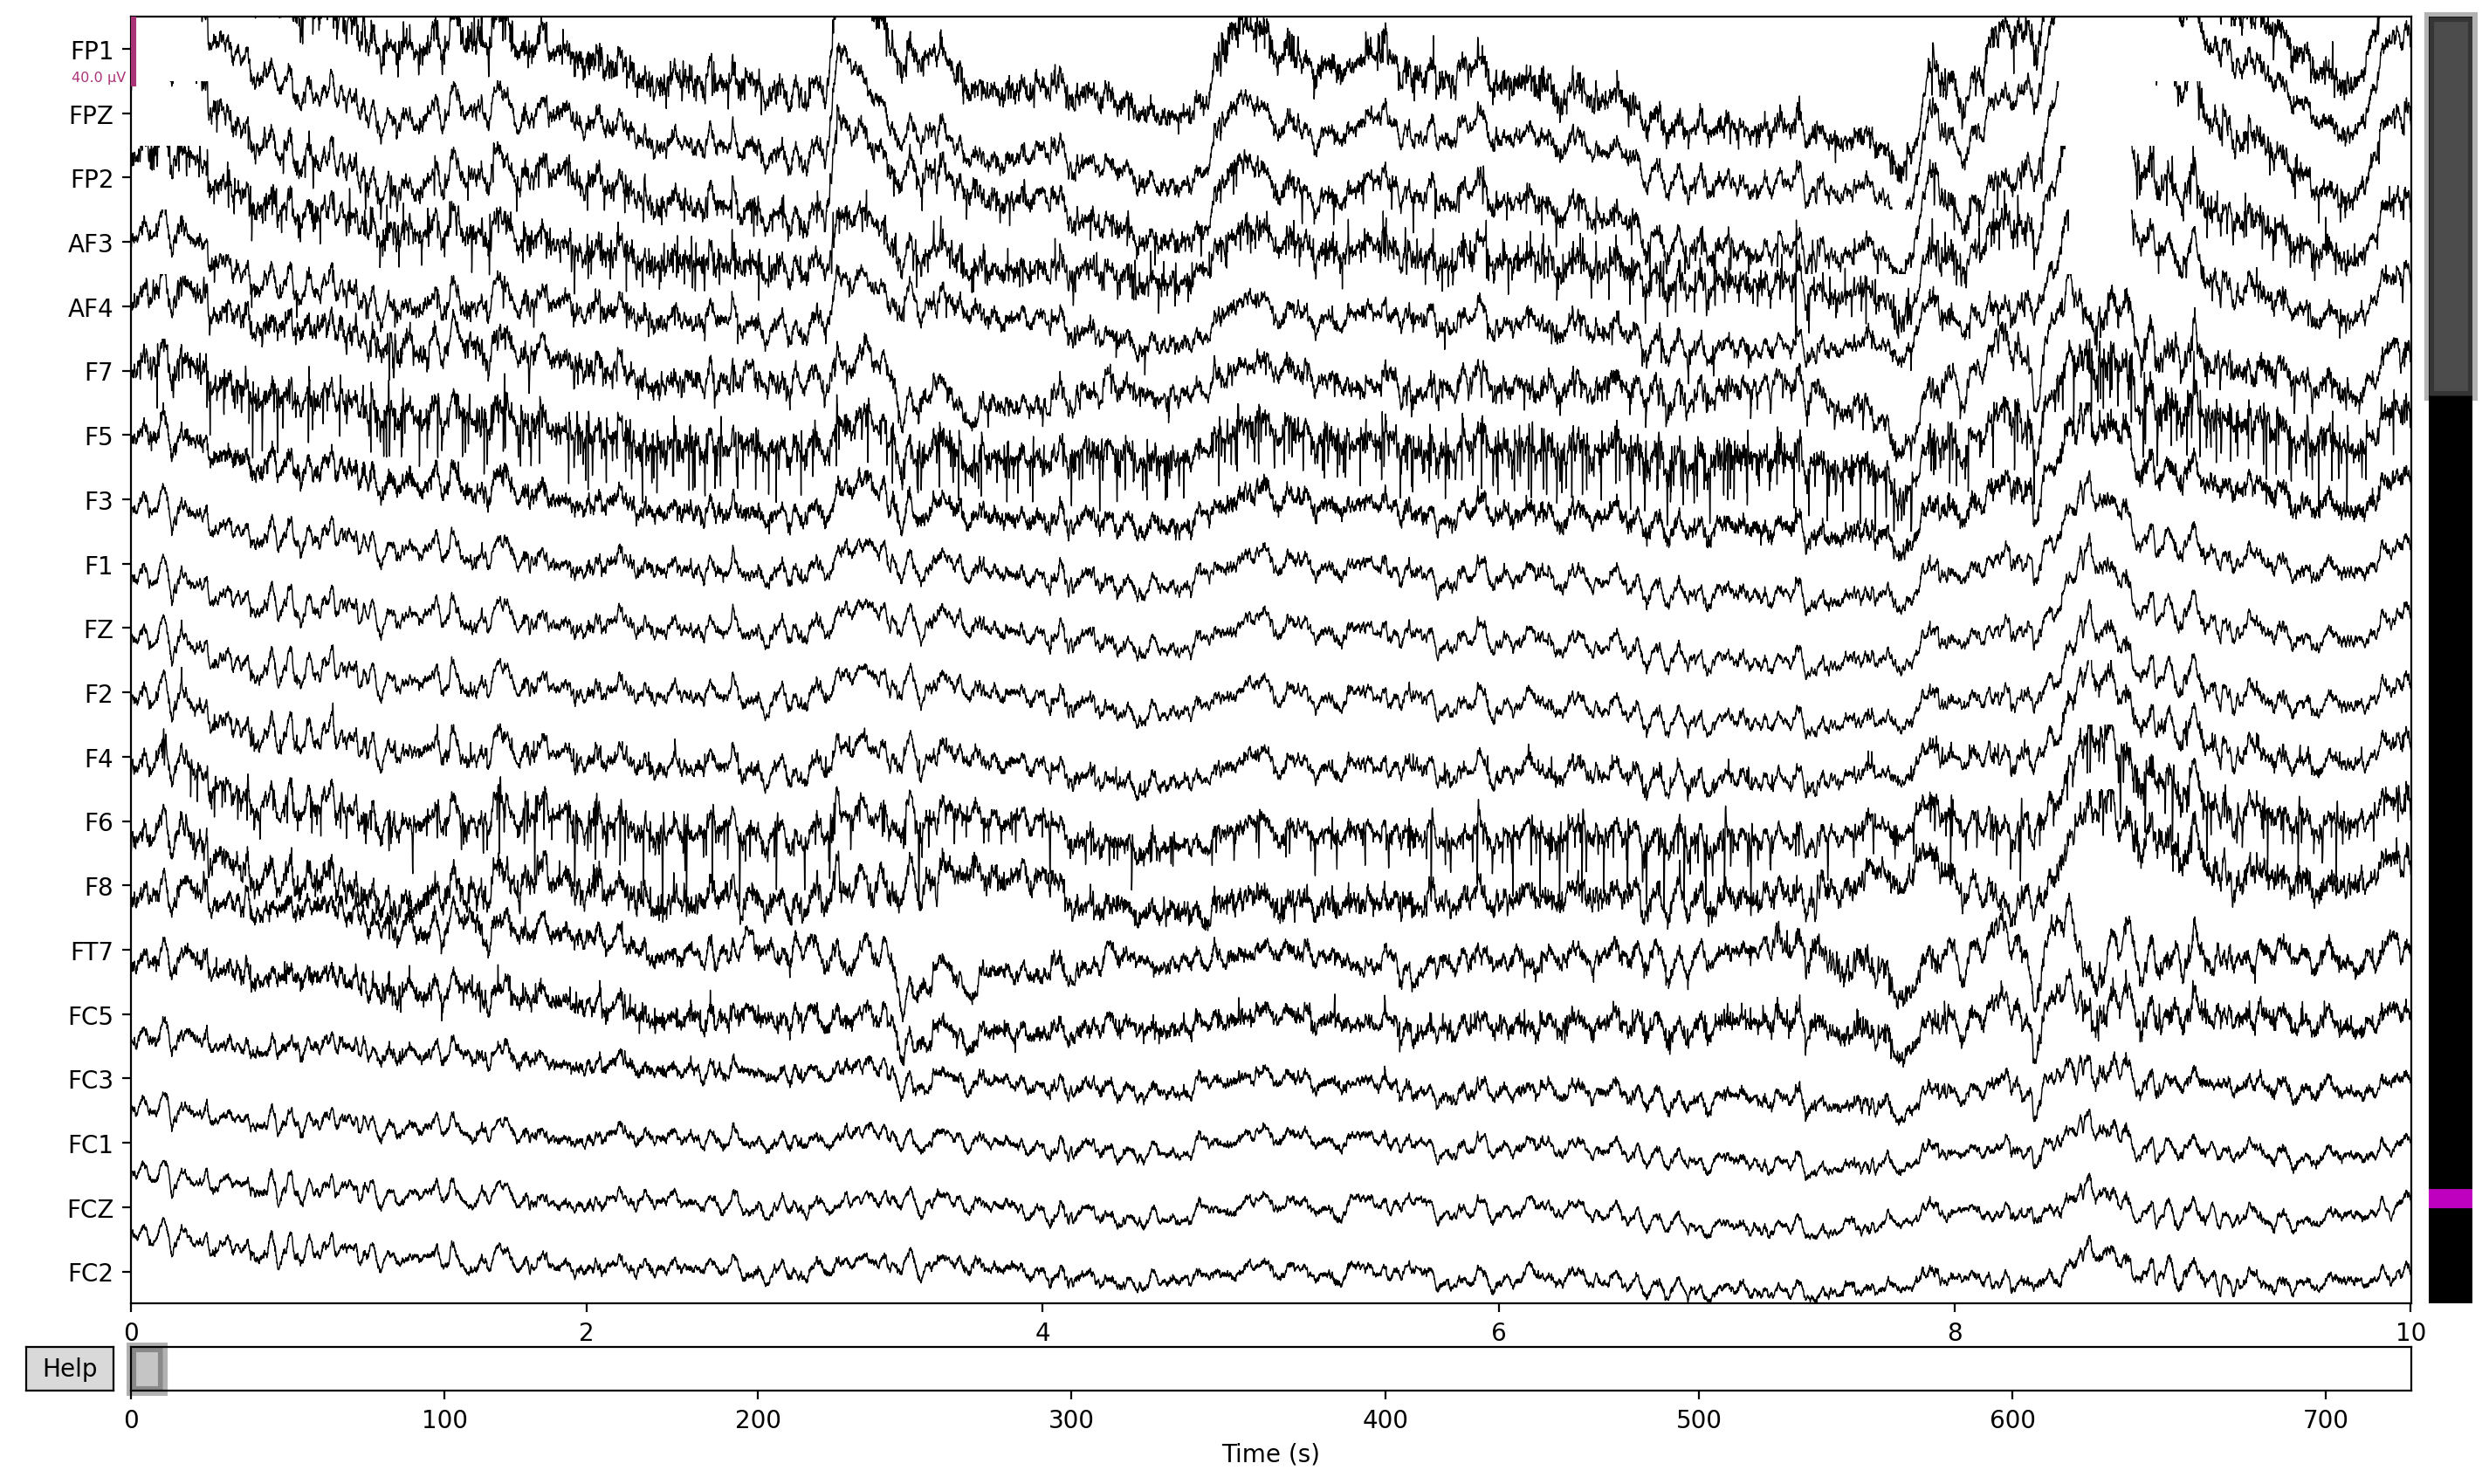

Channels marked as bad: none
Channels marked as bad: none


In [30]:
raw.plot()

## filter

A high-pass fitlter is a good first step before doing ICA, otherwise low frequency drift can throw off component detection.

In [31]:
raw = raw.filter(0.5, None) # low, high freq limit

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 sec)



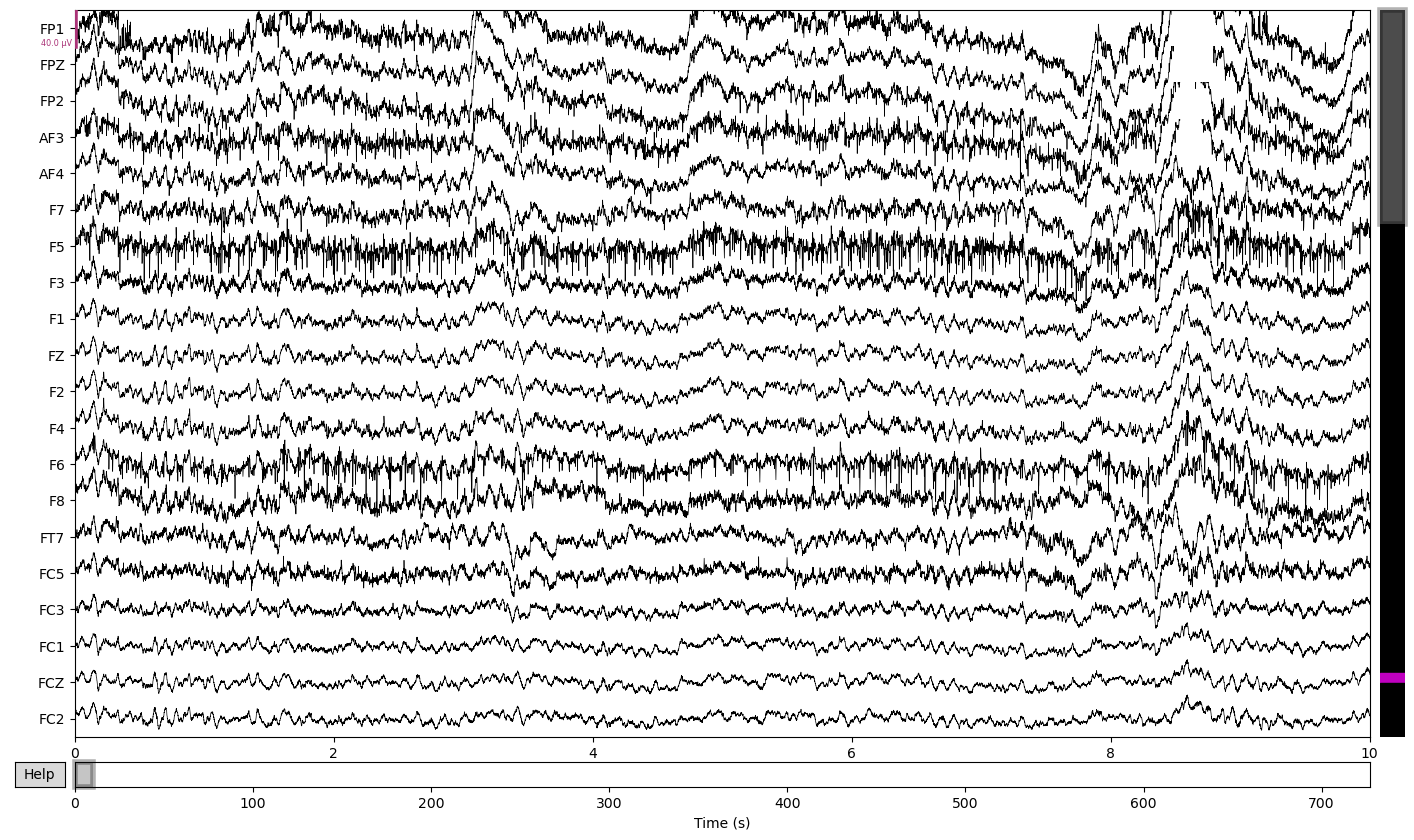

Channels marked as bad: none


In [32]:
raw.plot()

Effective window size : 2.048 (s)


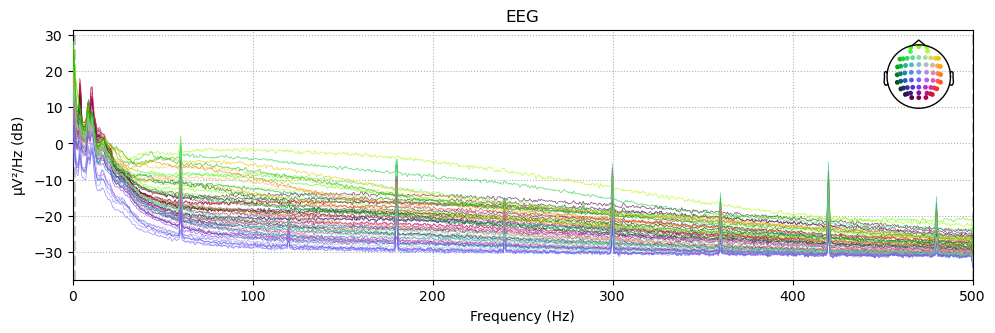

In [33]:
raw.plot_psd()

## visualize EOG artifacts

Here I just picked a few frontal electrodes that I knew were contaminated with eyeblink artifacts.

Using EOG channels: FPZ, FP1, FP2
EOG channel index for this subject is: [0 1 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 59 significant peaks
Number of EOG events detected: 59
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
Loading data for 59 events and 1001 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
No projecto

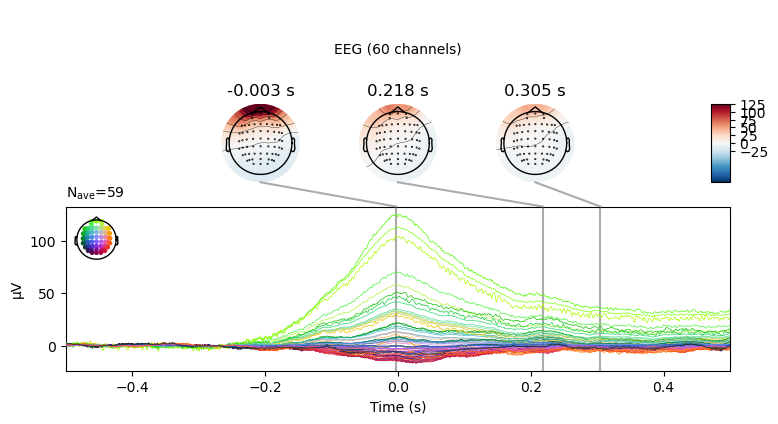

In [36]:
eog_evoked = create_eog_epochs(raw, ch_name=['FPZ', 'FP1', 'FP2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

## ICA

Finds mathematical components that explain the largest amount of variance in the data. Each has a spatial distribution and can be isolated and removed from the data (like an eyeblink artifact)

In [37]:
method = 'fastica'
seed=0

# Choose other parameters
n_components = 15  # if float, select n_components by explained variance of PCA
#decim = 5  # we need sufficient statistics, not all time points -> saves time

ica = ICA(n_components=n_components, method=method, max_iter='auto', random_state=seed)
ica.fit(raw, picks='eeg')

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.0s.


<ICA | raw data decomposition, method: fastica (fit in 27 iterations on 727080 samples), 15 ICA components explaining 98.6 % of variance (60 PCA components available), channel types: eeg, no sources marked for exclusion>

In [38]:
# plot spatial properties of all the ICA components, which can give info about the identity of the component
# for example, an eyeblink component has a clear frontal distribution

ica.plot_components()

[<MNEFigure size 975x731 with 15 Axes>]

Creating RawArray with float64 data, n_channels=18, n_times=727080
    Range : 0 ... 727079 =      0.000 ...   727.079 secs
Ready.


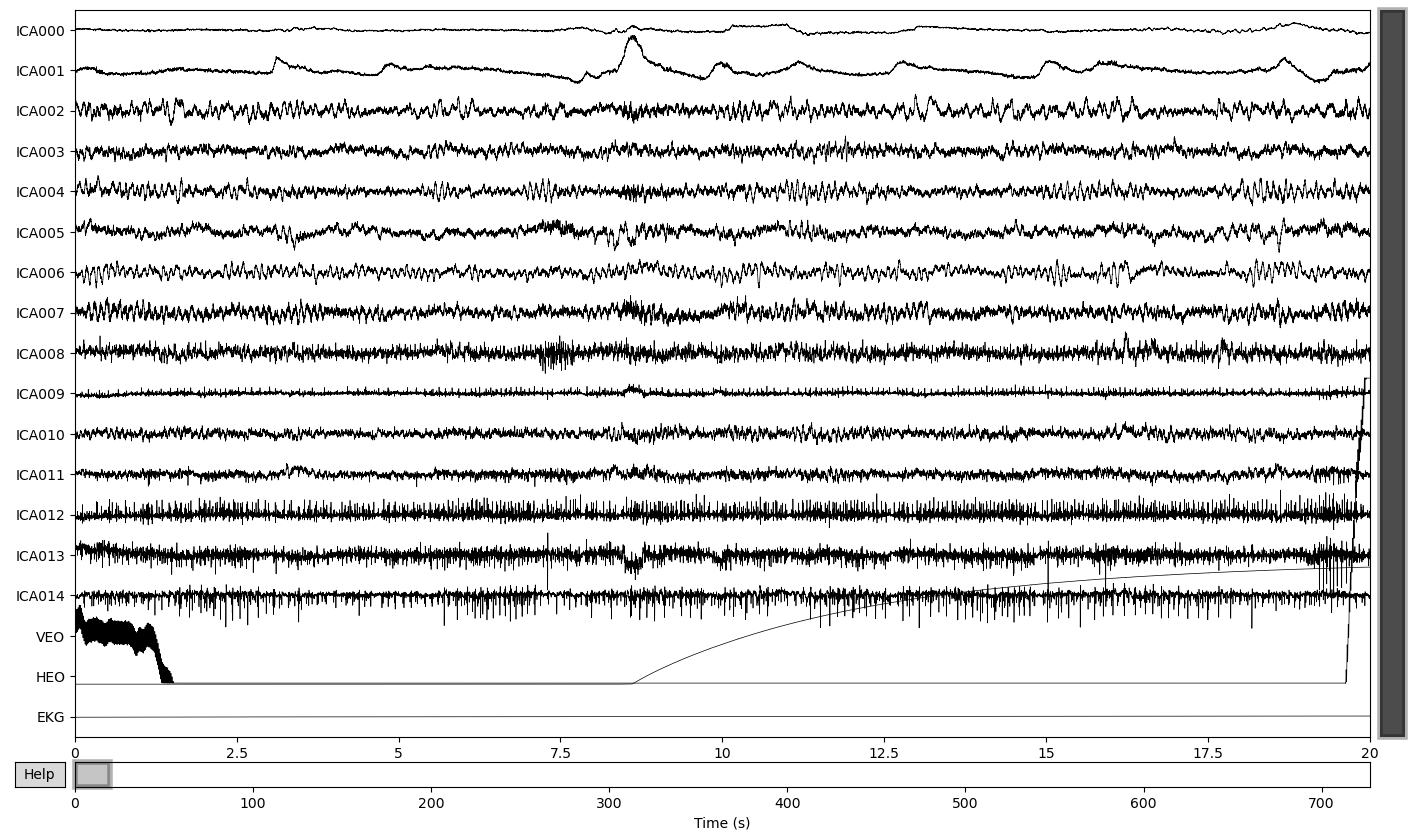

In [39]:
ica.plot_sources(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


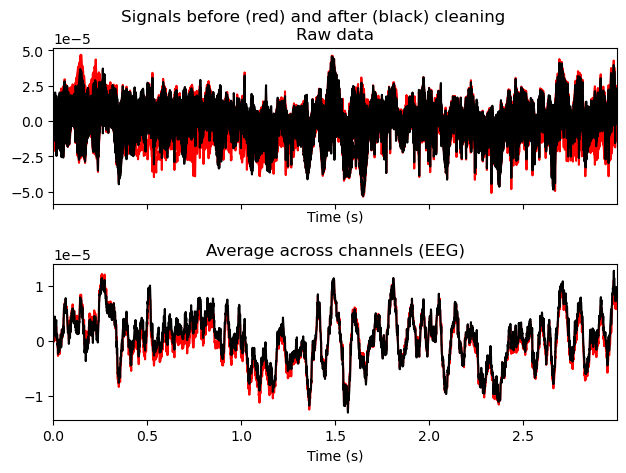

In [42]:
# this just shows what it looks like when you exclude a component vs when it's removed

ica.plot_overlay(raw, exclude=[1], picks='eeg')

In [43]:
# a more detailed look at different components you might be suspicious of
ica.plot_properties(raw, picks=[0,1,5])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [70]:
# exclude the components you're reasonably sure aren't brain activity 
exclude_components = [0,2,3]

In [71]:
# make a copy of raw and apply the exclusions to it
ica.exclude.extend(exclude_components)
raw_copy = raw.copy()
ica.apply(raw_copy)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 70 PCA components


<RawEDF | EEG1.bdf, 72 x 130048 (508.0 s), ~71.5 MB, data loaded>

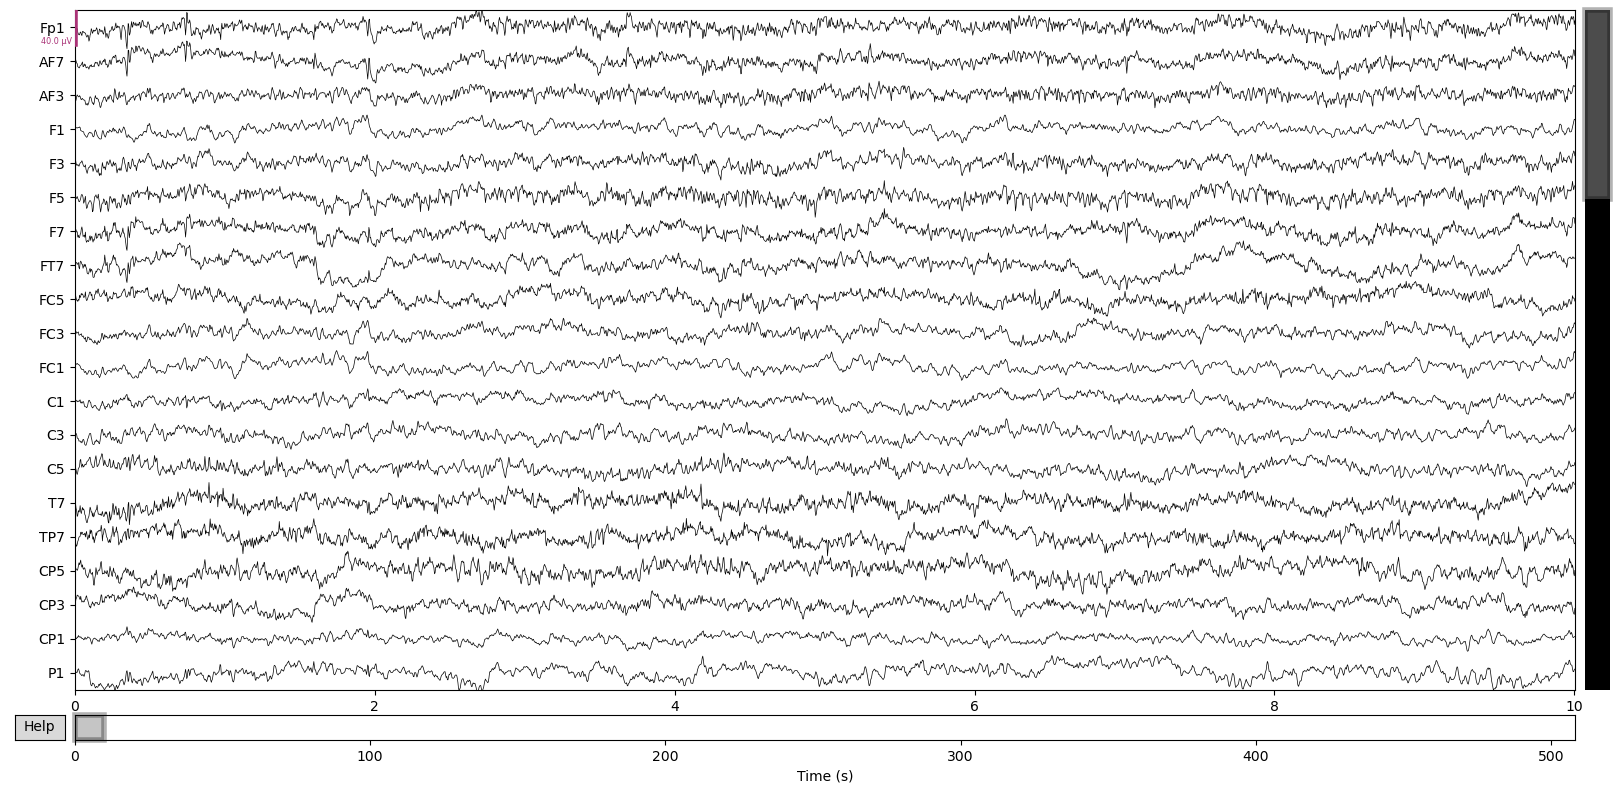

Channels marked as bad: none


In [72]:
# plot the raw copy with the exluded components as a sanity check

raw_copy.plot()

### save cleaned EEG file

In [73]:
raw_copy.save(save_path+save_filename, overwrite=True)

Writing /Volumes/VLABB/EMBARC/clean_data/CU_CU0016_1R1_eeg.fif
Closing /Volumes/VLABB/EMBARC/clean_data/CU_CU0016_1R1_eeg.fif
[done]
